In [1]:
import os
import pickle
import cv2
import numpy as np
import math
import time
import sys 
from scipy.spatial import Voronoi, voronoi_plot_2d

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

from jetbot import bgr8_to_jpeg
from jetbot import ObjectDetector
from jetbot import Camera
from jetbot import Robot

### Dijkstra code - for computing shortest path

https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/

In [2]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

def dijsktra(graph, initial, end):
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

## Shared Functions (will be moved to .py files later on)

In [3]:
def distance(pt1, pt2):
    """ Distance between 2 points """
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.linalg.norm(pt1-pt2)

def normalize_angle(angle):
    """ Normalize angle to between +pi and -pi """
    """ Important for EKF Correction Step !!!  """
    return (angle+math.pi)%(2*math.pi)-math.pi

""" =================== """        
""" Robot Mobility      """
""" =================== """

def control2robot(wheel_radius, axle_length):
    """ transform wheel speeds to robot motion in world frame """
    l = axle_length
    r = wheel_radius

    return np.array([[r/2, r/2],
                  [r/l, -r/l]])

def omega2speed(in_val, mapping, debug=False):
    """ Map wheel angular speed to motor speed setting based on a calibration mapping """
    
    if in_val < 0:
        sign = -1
        in_val = abs(in_val)
    else:
        sign = 1
        
    out_lower = 0
    in_lower = 0
    out_val = 0

    for i, in_upper in enumerate(mapping["omega"]):
        if debug:
            print (i, in_upper)
        if in_val < in_upper:
            out_upper = mapping["speed"][i]
            out_val = out_lower + (in_val - in_lower)/(in_upper - in_lower) \
                *(out_upper-out_lower)
            if debug:
                print("yes", out_val)
            break
        else:
            if debug:
                print("no")
            out_lower = mapping["speed"][i]
            in_lower = in_upper
            
    if out_val is 0:
        print ("Input is too high!!!", in_val)
        out_val = 0
        
    return sign*out_val

def clamp(wheel_velocities, upper_limit, lower_limit, T, debug=False):
    """ Place limits on motor speed --> improve open-end control reliability """
    
    robot_velocities = np.dot(T, wheel_velocities)  # get (tranl_vel, ang_vel)
    print(robot_velocities)
    tranl_velocity = robot_velocities[0,0]
    
    # Set lower limit on translational speed to 0.15m/s (motor setting 0.3)
    if abs(tranl_velocity) < lower_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * lower_limit
        if debug:
            print("Robot speed boosted", robot_velocities) 
    # Set upper limit on translational speed to 0.49m/s (motor setting 0.5)
    elif abs(tranl_velocity) > upper_limit:
        robot_velocities[0,0] = tranl_velocity/abs(tranl_velocity) * upper_limit
        if debug:
            print("Robot speed limited", robot_velocities)
            
    ang_velocity = robot_velocities[1,0]
    ang_upper_limit = 5.0
    if abs(ang_velocity) > ang_upper_limit:
        robot_velocities[1,0] = ang_velocity/abs(ang_velocity) * ang_upper_limit
        if debug:
            print("Rotational speed limited", robot_velocities)
            
    # return clamped wheel velocities
    return np.dot(np.linalg.pinv(T), robot_velocities)

def calc_wheel_velocities(direction='L', arc_radius=0.5, min_ang_vel=3.85, \
       wheel_radius=0.0325, axle_length=0.12, debug = False):
    """ Calculate wheel velocities to generate forward arc motion of provided radius """

    radius = arc_radius
    axle = axle_length
    
    if direction is 'L':
        """ If left turn, angular velocity of right wheel should be higher.
        Set angular velocity of left wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        l_ang_vel = min_ang_vel
        r_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    else:
        """ If right turn, angular velocity of left wheel should be higher.
        Set angular velocity of right wheel to minumum (e.g. 3.85--> motor setting of 0.3) """
        r_ang_vel = min_ang_vel    
        l_ang_vel = (min_ang_vel*2)/(2*radius/axle-1)+min_ang_vel
    
    if debug:
        print ("Left angular velocity:",l_ang_vel, " Right angular velocity:",r_ang_vel)
        T = control2robot(wheel_radius, axle_length)
        robot_velocities = np.dot(T, np.array([[r_ang_vel],[l_ang_vel]]))
        print ("Robot velocities:", robot_velocities)
        print("arc radius = ",abs(robot_velocities[0,0]/robot_velocities[1,0]))
    
    return np.array([[r_ang_vel],[l_ang_vel]])

""" =================== """        
""" Camera Functions    """
""" =================== """

def undistort(img, mtx, dist, crop=False):
    """Undistort camera image based on calibration data"""
    h,w = img.shape[:2]
    # print (h,w)
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image (optional)
    if crop:
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
    return dst

def draw_bbox(img, width, height, bbox, color, line_width):
    bbox_pixel = [(int(width * bbox[0]), int(height * bbox[1])), 
                  (int(width * bbox[2]), int(height * bbox[3]))]
    cv2.rectangle(img, bbox_pixel[0], bbox_pixel[1], color, line_width)
    return bbox_pixel

def valid_bbox(bbox, width, height):
    """ Detect if an object borders the 4 edges of the camera image plane. 
    Used to disregard a landmark for range and bearing estimation. """
    return (width * bbox[0]>10) and \
           (width * bbox[2]<width-10) and \
           (height * bbox[1]>10) and \
           (height * bbox[3]<height-10)

def draw_landmarks(img, landmarks, width, height, debug=False):
    """ put blue bounding boxes on detected objects on image """
    
    for item in landmarks:
        label = COCO_labels[item['label']-1]
        bbox = item['bbox']
        bbox_pixel = draw_bbox(img, width, height, bbox, BLUE, 1)
        if debug:
            print(label,item['label'], bbox_pixel)
    return

def landmark_coordinates(item, width, height):
    """ calculate landmark's left, center and right in image pixel coordinates """
    u_left = item['bbox'][0] * width
    u_right = item['bbox'][2] * width
    u_center = (item['bbox'][0]+item['bbox'][2])*width/2
    return u_left, u_center, u_right

""" ======================== """        
""" Open-End Circular Motion """
""" ======================== """

def take_circ_step(robot_params, direction, radius, debug=False, motion=True):
    """ Open-end control for circular motion - Taking one step in the trajectory """

    # load robot control parameters
    start_x = robot_params["start_x"]
    start_y = robot_params["start_y"]
    wheel_radius = robot_params["wheel_radius"]
    axle_length = robot_params["axle_length"]
    motor_on_time = robot_params["motor_on_time"]
    motor_off_time = robot_params["motor_off_time"]
    min_ang_velocity = robot_params["min_ang_velocity"]
    
    """ Generate clamped wheel velocities based on turn direction and radius """
    wheel_velocities = calc_wheel_velocities(direction='L', arc_radius=radius, \
        min_ang_vel=min_ang_velocity, \
        wheel_radius=wheel_radius, axle_length=axle_length, debug = debug)
    
    """ Map wheel angular velocities to motor setting, then run motors """ 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
    if debug:
        print ("L motor:", w_l," R motor:", w_r)
    
    """ Run motor step motion """
    if motion:
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
    
    return wheel_velocities


""" =================== """        
""" EKF Functions       """
""" =================== """

def initialize_Mu_Sigma(x,y,theta,landmark_list):
    """ Initialize Mu and Sigma """
    # Initialize Mu
    Mu = np.array([[x],[y],[theta]])
    for object in range(len(landmark_list)):
        Mu = np.vstack((Mu,np.array([[0],[0]])))
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks

    # Initialize Sigma - For Σ_mm, infinity (large num) along the diagonal and zero everywhere else 
    Sigma = np.zeros((N,N))
    Sigma[3:,3:] = np.eye(N-3)*LARGE
    
    return Mu, Sigma

def robot_pose_delta(v,w,theta,dt):
    """ Calculate change in robot pose in world frame """
    
    """ An alternate way - can avoid divide by zero error if w is zero
    x_delta = v*dt*math.cos(theta)
    y_delta = v*dt*math.sin(theta)
    """
    arc_radius = v/w   # arc radius
    
    x_delta = arc_radius*(math.sin(theta+w*dt)-math.sin(theta))
    y_delta = arc_radius*(math.cos(theta)-math.cos(theta+w*dt))
    theta_delta = w*dt
    
    return x_delta, y_delta, theta_delta

def compute_G_t(v,w,theta,dt,N):
    """ Calculate G_t matrix """ 
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    
    """ An alternate way to avoid divide by zero error if w is zero """
    """ TBD """
    
    arc_radius = v/w   # arc radius
    
    d_x_delta = arc_radius*(math.cos(theta+w*dt)-math.cos(theta))
    d_y_delta = arc_radius*(-math.sin(theta)+math.sin(theta+w*dt))
    
    G_x_t = np.array([[0,0,d_x_delta],[0,0,d_y_delta],[0,0,0]])
    G_t = np.eye(N)+ np.dot(np.dot(F.T, G_x_t),F)
    
    return G_t

def prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N):
    """
    Implement: 
         Mu_t = g(Mu_t-1, u_t) 
         Sigma_t = G_t.Sigma_t-1.G_t^T + F^T.R_t.F
    """
    F = np.zeros((3,N))
    F[0:3,0:3] = np.eye(3)
    Mu = Mu + np.dot(F.T, np.array([[x_delta],[y_delta],[theta_delta]]))
    Sigma = np.dot(np.dot(G_t, Sigma),G_t.T) + np.dot(np.dot(F.T, R_t),F)
    
    return Mu, Sigma
    
def estimate_range_bearing(landmarks, index, u_l, u_c, u_r, c_u, focal_length,\
                           correct_factor, camera_offset):
    """ Estimate landmark range (r) and bearing (phi) """
    
    j = index  # j is landmark index
    landmark_width = landmarks[j]['width']   # we know landmark's real width
    
    # First calculate range and bearing from camera's focal center
    phi = math.atan2(c_u-u_c, f_u) # phi is +ve if landmark is left of focal center
    depth = f_u/(u_r-u_l)*landmark_width*correct_factor-focal_length
    r = depth/math.cos(phi)

    # Next calculate range and bearing from robot's center of motion
    true_phi = math.atan2(r*math.sin(phi), depth+focal_length+camera_offset)
    true_r = (depth+focal_length+camera_offset)/math.cos(true_phi)
    
    return true_r, true_phi

def update_landmark_Mu(Mu, j, r, phi):
    """ Update j-th landmark's x and y coordinate in Mu """
    
    x = Mu[0,0] 
    y = Mu[1,0] 
    theta = Mu[2,0]
    
    Mu[3+2*j,0] = x + r*math.cos(phi+theta)
    Mu[3+2*j+1,0] = y + r*math.sin(phi+theta)
    
    return Mu

def get_observation(Mu, j):
    """ Get landmark's updated observation """
    robot_x = Mu[0,0] 
    robot_y = Mu[1,0] 
    robot_theta = Mu[2,0]
    landmark_x = Mu[3+2*j,0]
    landmark_y = Mu[3+2*j+1,0]
    delta_x = landmark_x-robot_x
    delta_y = landmark_y-robot_y
    
    delta = np.array([[delta_x],[delta_y]])
    q = np.asscalar(np.dot(delta.T, delta))
    # important to normalize orientation (otherwise fatal error in EKF!!!)
    phi = normalize_angle(math.atan2(delta_y,delta_x)-robot_theta)
    z_t_hat = np.array([[math.sqrt(q)],[phi]])

    return delta, q, z_t_hat

def compute_H_t(delta, j, q, N):             
    """ Compute H_t matrix """     
    delta_x = delta[0,0]
    delta_y = delta[1,0]  
    
    F = np.zeros((5,N))
    F[0:3,0:3] = np.eye(3)
    F[3:5,3+2*j:3+2*j+2] = np.eye(2)
            
    sqrt_q = math.sqrt(q)
    H_j = np.array([[-sqrt_q*delta_x, -sqrt_q*delta_y,   0, sqrt_q*delta_x, sqrt_q*delta_y],
                    [        delta_y,        -delta_x,  -q,       -delta_y,        delta_x]])
    H_t = 1/q*np.dot(H_j,F)
    
    return H_t

def compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t):
    """ Compute Kalman Gain K_t """         
    delta_x = delta[0,0]
    delta_y = delta[1,0]
            
    # Compute Kalman Gain K_t
    L = np.dot(np.dot(H_t, Sigma),H_t.T) + Q_t
    K_t = np.dot(np.dot(Sigma, H_t.T),np.linalg.inv(L))
    
    return K_t


""" ================================ """        
""" Pursuit-based Path Following     """
""" ================================ """

def generate_points(start, end, interval, debug=False):
    """ Generate a sequence of equally distance points for a path """
    start_x, start_y = start
    end_x, end_y = end
    theta = math.atan2((end_y-start_y),(end_x-start_x))
       
    if debug:
        print("From {} to {}".format(np.around(np.array(start),3), np.around(np.array(end),3)))
        print("theta: {:.1f}".format(theta))
    
    points = []
    current_pt = start
    next_pt = start
    
    # Generate a sequence of points from start to end
    while distance(start,next_pt) < distance(start,end):
        points.append(current_pt)
        next_pt = (current_pt[0] + interval*math.cos(theta), current_pt[1]+interval*math.sin(theta))
        current_pt = next_pt
        
    return points

def generate_trajectory(path, vor, interval, debug=False):
    """ Convert path into points for robot to follow """
    
    points = []
    # for each path segment
    for i in range(len(path)-1):
        # generate points for the segment
        start = [vor.vertices[int(path[i]), 0],vor.vertices[int(path[i]), 1]]
        end = [vor.vertices[int(path[i+1]), 0],vor.vertices[int(path[i+1]), 1]]
        if debug:
            print(path[i], path[i+1])
        points.extend(generate_points(start,end,interval)) 
        
    return points

def closest_point(traj, robot_pose):
    """ Pick the next point in the trajectory to pursue """
    robot_x = robot_pose[0]
    robot_y = robot_pose[1]
    robot_theta = robot_pose[2]
    
    current = traj["current"]
    points = traj["points"][current:]
    
    nearest = None
    # Go through all pts in trajectory and pick the pt nearest to robot
    for i, pt in enumerate(points):
        if nearest is None:
            nearest = pt
        else:
            if distance(pt,[robot_x,robot_y])<distance(nearest,[robot_x,robot_y]):
                nearest = pt
                current = traj["current"]+i
                
    return current, nearest

def last_pt(trajec_params):
    """ Return true if current pt is the last pt of the trajectory """
    if trajec_params["current"] == len(trajec_params["points"]):
        # Return None if already at the last pt of trajectory
        return True
    else:
        return False
    

def next_pursuit_pt(robot_pose, pursuit_pt, trajec_params):
    """ Provide next pursuit point to robot if available or if necessary """
    
    if last_pt(trajec_params):
        # Return None if already at the last pt of trajectory
        return None
    else:
        # Look for suitable next pursuit pt in trajectory
        while distance(robot_pos,pursuit_pt)<0.10:
            trajec_params["current"] += 1  # set next pt in trajectory as pursuit pt
            if last_pt(trajec_params):
                # Return None if reaches the last pt of trajectory
                return None
            pursuit_pt = trajec_params["points"][trajec_params["current"]]
            
    return pursuit_pt


""" =================== """        
""" Map Generation      """
""" =================== """

def in_blocked_area(blocked, point):
    """ Check if a point falls within a blocked region """
    x,y = point
    ULeft_x, ULeft_y = blocked[0]
    LRight_x, LRight_y = blocked[1]
    
    if (ULeft_x<=x<=LRight_x) and (ULeft_y>=y>=LRight_y):
        return True
    else:
        return False
    
def valid_point(blocked_areas, point):
    """ A point is valid if it does not wihin a list of blocked regions """
    for area in blocked_areas:
        if in_blocked_area(area, point):
            return False

    return True

def display_landmarks(landmarks):
    """ Display landmarks """
    for i, landmark in enumerate(landmarks):
        # Mark landmark's actual locations (red crosses)
        landmark_x_actual = landmark["actual_x"]*100
        landmark_y_actual = landmark["actual_y"]*100
        plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red')
        
        # Mark areas blocked by landmarks (blue crosses)
        if landmark["blocked"] is not None:
            plt.scatter(landmark["barrier"][:,0]*100, landmark["barrier"][:,1]*100, marker='*', color='blue')
    return

def display_barriers(barriers):
    """ Display non-landmark blocked regions """
    for barrier in barriers:
        # Mark areas blocked by barriers (blue crosses)
        points = barrier["barrier"]
        plt.scatter(points[:,0]*100, points[:,1]*100, marker='*', color='blue') 
    return

def display_environ(landmarks, barriers, display_param):
    """ Display map of environments - landmarks and blocked regions """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])

    display_landmarks(landmarks)
    display_barriers(barriers)

    plt.show()
    plt.close()
    
    return

def display_edges(edges, vor):
    """ Display path formed from voronoi vertices """
    x = []
    y = []
    for edge in edges:
        idx1, idx2, _ = edge
        simplex = np.asarray([int(idx1),int(idx2)]) 
        x = vor.vertices[simplex, 0] 
        y = vor.vertices[simplex, 1]
        plt.plot(x,y,'k-', color="black")    
    return

def display_path(path, vor):
    """ Display path formed from voronoi vertices """
    x = []
    y = []
    for pt in path:
        idx = int(pt)
        x.append(vor.vertices[idx, 0])  
        y.append(vor.vertices[idx, 1])
        # print (pt,x,y)
    
    plt.plot(x,y,'k-', color="black")    
    return

def display_voronoi_edges(points, vor, edges, display_param):
    """ Display voronoi diagram - points, vertices and paths """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Display points and vertices
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # display edges
    display_edges(edges, vor)
    
    plt.show()
    plt.close()
    
    return

def display_voronoi_path(points, vor, path, display_param):
    """ Display voronoi diagram - points, vertices and paths """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Display points and vertices
    plt.plot(points[:, 0], points[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # display path
    display_path(path, vor)
    
    plt.show()
    plt.close()
    
    return

def update_map(Mu, landmarks, Mu_prev=None, folder=None, ind=None, debug=False):
    """ Update robot position on map """
    plt.figure(figsize=(8,8))
    plt.xlim([-100,250])
    plt.ylim([-100,250])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(normalize_angle(Mu[2,0])*180/math.pi))
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')
    
    """ Display landmark as green cross, uncorrected landmark as lime cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            # Mark landmark's actual locations
            landmark_x_actual = landmark["actual_x"]*100
            landmark_y_actual = landmark["actual_y"]*100
            plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red') 
            # Mark landmark (post-Kalman correction)
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='blue')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    
    if (folder is not None) and (ind is not None):
        file_path = os.path.join(folder, 'map_'+str(ind+1).zfill(3)+'.png')
        plt.savefig(file_path)
    else:
        plt.show()
        
    plt.close()
    return

def animate_robot(robot_pose, landmarks, vor, display_param, path=None, pursuit_pt=None):
    """ Update map to display landmarks, robot, trajectory and pursuit point """
    
    # Load display parameters
    plt.figure(figsize=display_param["figsize"]) 
    plt.xlim(display_param["xlim"]); plt.ylim(display_param["ylim"])
    
    # Plot landmarks and voronoi vertices
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'o')
    plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
    
    # Plot trajectory
    if path is not None:
        path = np.array(path)
        plt.plot(path[:,0],path[:,1], 'x')
    
    # Plot robot pose (robot = line + triangle)
    robot_x_actual = robot_pose[0]
    robot_y_actual = robot_pose[1]
    robot_theta_actual = robot_pose[2]*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')

    # Plot pursuit pt
    if pursuit_pt is not None:
        plt.plot(pursuit_pt[0],pursuit_pt[1], 'x', c='r')

    plt.show()
    plt.close()
    
    return

## Landmarks and Central Barrier

To be used for generating Voronoi diagrams.

In [49]:
# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.75-0.05,1.50+0.05],[0.75+0.05,1.50-0.05]],    
    "barrier": np.array([[0.75+0.05,1.50+0.05],
                    [0.75+0.05,1.50-0.05],
                    [0.75-0.05,1.50-0.05],
                    [0.75-0.05,1.50+0.05]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.25,
    "actual_y": 1.34,
    "Mu": [],
    "blocked": [[-0.85-0.6,1.34+0.84],[-0.85+0.6,1.34-0.84]],    
    "barrier": np.array([[-0.85-0.6,1.34+0.84],
                    [-0.85+0.6,1.34+0.84],
                    [-0.85+0.6,1.34+0.42],                         
                    [-0.85+0.6,1.34], 
                    [-0.85+0.6,1.34-0.42],
                    [-0.85+0.6,1.34-0.84],
                    [-0.85-0.6,1.34-0.84],
                    [-0.85-0.6,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 13,
    "obj_name": 'stop sign',
    "width": 0.12,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 0.75,
    "Mu": [],
    "blocked": [[1.50-0.05,0.75+0.1],[1.50+0.05,0.75-0.1]],    
    "barrier": np.array([[1.50-0.05,0.75+0.1],
                    [1.50-0.05,0.75-0.1],
                    [1.50+0.05,0.75+0.1],
                    [1.50+0.05,0.75-0.1]
                   ])
    },
    {
    "label": 62,
    "obj_name": 'stool',
    "width": 0.33,
    "observed": False,
    "actual_x": 2.2,
    "actual_y": -0.16,
    "Mu": [],
    "blocked": [[2.2,-0.16+0.16],[2.5,-0.16-0.16]],    
    "barrier": np.array([[2.2,-0.16+0.16],
                    [2.2,-0.16-0.16],
                    [2.5,-0.16+0.16],
                    [2.5,-0.16-0.16]
                   ])
    },
]

# Central barrier - 0.5m x 0.5m
barriers = [
    {
    "name": "Central",
    "barrier": np.array([[0.5,0.5],
                    [0.5,0.75],
                    [0.5,1.0],
                    [0.75,1.0],
                    [1.0,1.0],
                    [1.0,0.75],
                    [1.0,0.5],
                    [0.75,0.5]
                   ]),
    "blocked": [[0.5,1.0],[1.0,0.5]]
    }
]

### Plot Map

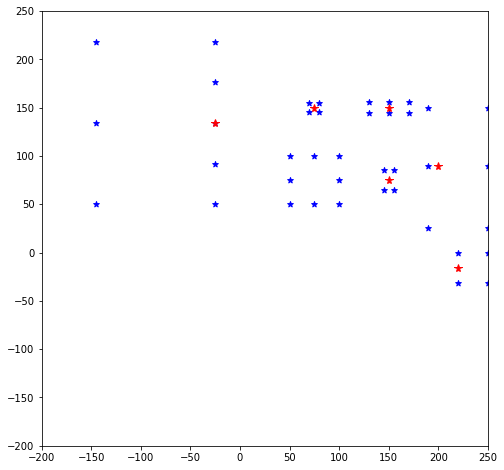

In [50]:
display_param = {
    "figsize": (8,8),
    "xlim": [-200,250],
    "ylim": [-200,250]
    }

display_environ(landmarks, barriers, display_param)

## Voronoi Diagram --> Legal Paths

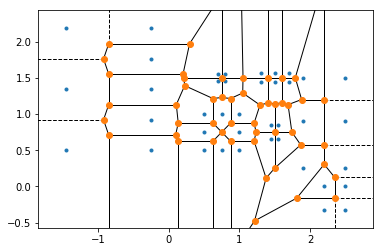

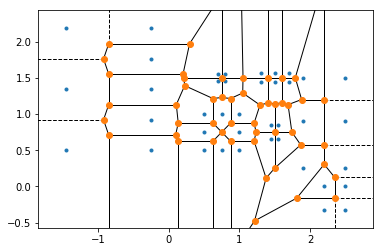

In [51]:
num_pt = 0
for landmark in landmarks:
    landmark_barrier = landmark["barrier"]
    num, _ = landmark_barrier.shape
    num_pt += num

for barrier in barriers:
    num, _ = barrier["barrier"].shape
    num_pt += num
    points = np.zeros((num_pt,2))

# create landmark points
j = 0
for landmark in landmarks:
    landmark_barrier = landmark["barrier"]
    num, _ = landmark_barrier.shape
    for i in range(num):
        points[j,0] = landmark_barrier[i,0]
        points[j,1] = landmark_barrier[i,1]
        j += 1
    
# create barrier points for blocked regions
for barrier in barriers:
    num, _ = barrier["barrier"].shape
    for i in range(num):
        points[j,0] = barrier["barrier"][i,0]
        points[j,1] = barrier["barrier"][i,1]    
        j += 1
    
vor = Voronoi(points)
voronoi_plot_2d(vor)

0 9 [-0.85    -5.36274] [ 0.125   -2.44963] 3.0719429439803725
4 8 [0.09667 0.71   ] [0.125 0.625] 0.08959786703810428
8 9 [0.125 0.625] [ 0.125   -2.44963] 3.0746341463414644
7 12 [0.29463 1.97   ] [0.20179 1.55   ] 0.4301391129735767
9 16 [ 0.125   -2.44963] [ 0.625   -1.41305] 1.1508732426735644
4 22 [0.09667 0.71   ] [0.13407 0.875  ] 0.1691855785816272
22 23 [0.13407 0.875  ] [0.10687 1.13   ] 0.25644656363461
12 21 [0.20179 1.55   ] [0.21284 1.5    ] 0.05120703725875915
21 24 [0.21284 1.5    ] [0.22541 1.39149] 0.1092391937916325
23 24 [0.10687 1.13   ] [0.22541 1.39149] 0.2871003694972435
6 27 [2.55784 7.63459] [1.6     4.62202] 3.1611822603518918
7 25 [0.29463 1.97   ] [0.75    2.65667] 0.8239365934360955
25 26 [0.75    2.65667] [1.019 3.105] 0.5228420199044618
26 28 [1.019 3.105] [1.4    4.0575] 1.0258738957591231
27 28 [1.6     4.62202] [1.4    4.0575] 0.5988977040677013
6 13 [2.55784 7.63459] [2.2     2.86333] 4.784658040150585
24 33 [0.22541 1.39149] [0.625   1.21389] 0.437

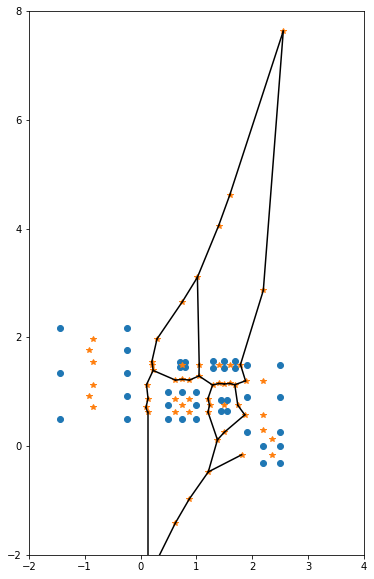

In [52]:
# Build a list of blocked areas
blocked_areas = []
for barrier in barriers:
    blocked_areas.append(barrier["blocked"])
for landmark in landmarks:
    blocked_areas.append(landmark["blocked"])
        
# Graph for shortest distance computation
graph = Graph()
edges = []

# plot parameters
display_param = {
    "figsize": (6,10),
    "xlim": [-2, 4],
    "ylim": [-2, 8]
    }

for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    start = vor.vertices[simplex[0]]
    end = vor.vertices[simplex[1]]
    
    """ Graph edges connect valid points, which are non-infinity points that are not in any blocked region """ 
    if np.all(simplex >= 0) and (valid_point(blocked_areas,start) and valid_point(blocked_areas,end)):
        dist = np.linalg.norm(start-end)
        edges.append((str(simplex[0]),str(simplex[1]),dist))
        # print out for to keep record
        print(str(simplex[0]),str(simplex[1]), start, end, dist)

display_voronoi_edges(points, vor, edges, display_param)

## Shortest Path Search

['17', '43', '53', '52', '51', '18', '46', '44', '45', '33']


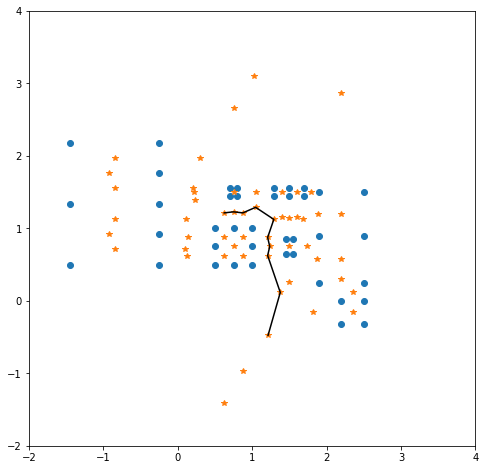

In [53]:
for edge in edges:
    graph.add_edge(*edge)
    
shortest = dijsktra(graph, '17', '33')
print(shortest)

# plot parameters
display_param = {
    "figsize": (8,8),
    "xlim": [-2, 4],
    "ylim": [-2, 4]
    }
display_voronoi_path(points, vor, shortest, display_param)

## Initialize JetBot

In [4]:
model = ObjectDetector('../Notebooks/object_following/ssd_mobilenet_v2_coco.engine')
camera = Camera.instance(width=300, height=300)
robot = Robot()

In [5]:
# Load COCO labels
filename = "coco_labels.dat"
filehandler = open(filename, 'rb')
COCO_labels = pickle.load(filehandler)

# Load camera calibration data for undistort
filename = "calibration.dat"
filehandler = open(filename, 'rb')
camera_cal = pickle.load(filehandler)
mtx = camera_cal['mtx']
dist = camera_cal['dist']
f_u = mtx[0,0]  # focal lengths in u pixels (image plane horizontal)
f_v = mtx[1,1]  # focal lengths in v pixels (image plane vertical)
c_u = mtx[0,2]  # focal center in u pixels (image plane horizontal)
c_v = mtx[1,2]  # focal center in v pixels (image plane vertical)
focal_center = np.array([c_u, c_v])

# Open Image Widget
image_widget = widgets.Image(format='jpeg', width=300, height=300)
width = int(image_widget.width)
height = int(image_widget.height)

BLUE = (255, 0, 0)
GREEN = (0, 255, 0)
RED = (0, 0, 255)

diag_dir = 'diagnostics'
# we have this "try/except" statement because these next functions can throw an error if the directories exist already
try:
    os.makedirs(diag_dir)
except FileExistsError:
    print('Directories not created because they already exist')

# Mapping between set_motor "speed" and measured wheel angular velocity "omega"
# for 0.1 second motor running time
wheel_calibration = {
    "speed": [0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "omega": [0.0, 3.85, 9.23, 15.0, 25.8, 29.2, 35.4]
}

Directories not created because they already exist


## EKF SLAM via Open-End Circular Motion

(x,y):75.0, 25.0
Orientation: 0.0


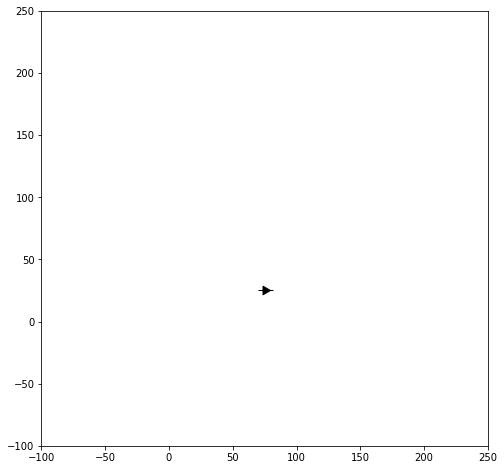

In [29]:
robot_params = {
    # pose
    "start_x": 0.75,
    "start_y": 0.25,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
    "focal_length": 0.00315 # camera focal lenght in meter
}

control_params = {
    "num_iter": 151,
    "interval": 5,
    "debug": False,
    "motion": True,
    "radius": 0.50,    # radius of circular trajectory
}

# Landmarks
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.75-0.05,1.50+0.05],[0.75+0.05,1.50-0.05]],    
    "barrier": np.array([[0.75+0.05,1.50+0.05],
                    [0.75+0.05,1.50-0.05],
                    [0.75-0.05,1.50-0.05],
                    [0.75-0.05,1.50+0.05]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.85,
    "actual_y": 1.34,
    "Mu": [],
    "blocked": [[-0.85-0.6,1.34+0.84],[-0.85+0.6,1.34-0.84]],    
    "barrier": np.array([[-0.85-0.6,1.34+0.84],
                    [-0.85+0.6,1.34+0.84],
                    [-0.85+0.6,1.34+0.42],                         
                    [-0.85+0.6,1.34], 
                    [-0.85+0.6,1.34-0.42],
                    [-0.85+0.6,1.34-0.84],
                    [-0.85-0.6,1.34-0.84],
                    [-0.85-0.6,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 61,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 1.5,
    "actual_y": 0,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    },
    {
    "label": 13,
    "obj_name": 'stop sign',
    "width": 0.12,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 0.75,
    "Mu": [],
    "blocked": [[1.50-0.1,0.75+0.1],[1.50+0.1,0.75-0.1]],    
    "barrier": np.array([[1.50-0.1,0.75+0.1],
                    [1.50-0.1,0.75-0.1],
                    [1.50+0.1,0.75+0.1],
                    [1.50+0.1,0.75-0.1]
                   ])
    },
    {
    "label": 62,
    "obj_name": 'stool',
    "width": 0.33,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": -0.16,
    "Mu": [],
    "blocked": [[2.0-0.16,-0.16+0.16],[2.0+0.16,-0.16-0.16]],    
    "barrier": np.array([[2.0-0.16,-0.16+0.16],
                    [2.0-0.16,-0.16-0.16],
                    [2.0+0.16,-0.16+0.16],
                    [2.0+0.16,-0.16-0.16]
                   ])
    },
]

landmark_item_list = []
for item in landmarks:
    landmark_item_list.append(item['label'])
    
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))
image = undistort(camera.value, mtx, dist) # undistort camera image
image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image

LARGE = 1e6
t_delta = 0.1  # motor on time
R_t = np.eye(3)*0.001  # Assume small constant control noise for now
Q_t = np.eye(2)*0.001  # Assume small constant  measurement noise for now

diag_dir = 'diagnostics'
np.set_printoptions(precision=5)

# Load camera parameters
focal_length = robot_params["focal_length"]
correct_factor = 1  # 0.769
camera_offset = robot_params["camera_offset"]

# Load robot parameters
wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
T = control2robot(wheel_radius,axle_length)
x = robot_params["start_x"]
y = robot_params["start_y"]
theta = robot_params["start_theta"]

# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"] 
radius = control_params["radius"] 

""" Initialize Mu and Sigma """
Mu, Sigma = initialize_Mu_Sigma(x,y,theta,landmark_item_list)
# Mu_prev = Mu
if debug:
    print(Mu)
    print(Sigma)

# Place robot (and landmark)on map
update_map(Mu, landmarks, debug=True)

In [30]:
# Display camera image with bounding boxes for detected objects
display(widgets.HBox([image_widget]))

""" Robot moves stepwise in a circle """
for i in range(num_iter):
    
    """ Move robot - Take 1 step in a left circular trajectory of radius 0.4m """
    wheel_velocities = take_circ_step(robot_params, 'L', radius, debug=debug, motion=motion)
    robot_velocities = np.dot(T,wheel_velocities)   # calculate (v,omega)
    if debug:
        print("Step: ", i+1)
        print("(w_r,w_l): {}".format(wheel_velocities))
        print("(v,omega): {}".format(robot_velocities))
        
    """ =================== """        
    """ EKF Prediction Step """
    """ =================== """
    
    v = robot_velocities[0,0]
    w = robot_velocities[1,0]
    theta = Mu[2,0]%(2*math.pi)  # robot orientation (normalize to 2*pi)
    N = Mu.shape[0]   # N=3+2n, n=num of landmarks
    
    # Calculate delta in robot's pose in the world frame
    x_delta, y_delta, theta_delta = robot_pose_delta(v,w,theta,t_delta)

    G_t = compute_G_t(v,w,theta,t_delta,N)  # Generate G_t 
    
    # Update Mu and Sigma based on change in robot pose
    Mu, Sigma = prediction_step_update(Mu, Sigma, x_delta, y_delta, theta_delta, G_t, R_t, N)
    
    if debug:
        print("(dx,dy,dtheta):{:.2f},{:.2f},{:.2f}".format(x_delta,y_delta,theta_delta))
        print("Mu:",Mu)
        # np.set_printoptions(suppress=True)
        print("G:",G_t)
        print("Sigma:",Sigma)
    
    """ Grab camera image, undistort and detect objects """
    image = undistort(camera.value, mtx, dist) # undistort camera image
    detections = model(image) # Use SSD model to detect objects
    
    """ Identify landmarks and estimate range(r)/bearing(phi) from robot """
    items = []
    for det in detections[0]:
        
        coco_id =det['label']
        if coco_id in landmark_item_list and valid_bbox(det["bbox"], width, height):
            """ If object detected is a landmark and its bounding box does not 
            borders the edges of the camera video """
            
            """ =================== """        
            """ EKF Correction Step """
            """ =================== """
            
            # Obtain landmark's left, center and right in horizontal pixel coordinate
            u_l, u_c, u_r = landmark_coordinates(det, width, height)
            j = landmark_item_list.index(coco_id)   # get landmark's index
            
            # Estimate landmark's range and bearing(r,phi) from robot
            r, phi = estimate_range_bearing(landmarks, j, \
                                            u_l, u_c, u_r, \
                                            c_u, focal_length, correct_factor, camera_offset)
            z_t = np.array([[r],[phi]])  # z_t - actual observation

            """ If landmark j encountered for 1st time, update (Mu_j_x, Mu_j_y) """
            if landmarks[j]['observed'] is False:
                # Update Mu's landmark coordinate
                landmarks[j]['observed'] = True
                Mu = update_landmark_Mu(Mu, j,  r, phi)

            # Get landmark j's expected observation
            delta, q, z_t_hat = get_observation(Mu, j)  # z_t_hat - expected observation
            
            # Compute H_t 
            H_t = compute_H_t(delta, j, q, N)  
            
            # Compute Kalmain Gain K_t
            K_t = compute_Kalman_Gain(delta, q, j, H_t, Sigma, N, Q_t)
            
            if debug:            
                print("Mu before Correction:", Mu)
                print("Kalman Gain", K_t)
                
            # Mu_prev = Mu
            # Mu = Mu_prev + np.dot(K_t, (z_t-z_t_hat))
            
            Mu = Mu + np.dot(K_t, (z_t-z_t_hat))
            Sigma = np.dot((np.eye(N)-np.dot(K_t,H_t)), Sigma)
            
            if True:
                print("Step: ", i+1)
                print("{} (left,center, right):{:.1f},{:.1f}, \
                {:.1f}".format(COCO_labels[coco_id-1], u_l, u_c, u_r))
                print("{} estimated phi:{:.1f} degree".format(COCO_labels[coco_id-1],phi/3.14*180))
                print("{} estimated range:{:.1f}cm".format(COCO_labels[coco_id-1],r*100)) 
                print("Mu after Correction:", Mu)
                print("robot: {:.1f},{:.1f}".format(Mu[0,0], Mu[1,0])) 
                print("{}: {:.1f},{:.1f}".format(COCO_labels[coco_id-1], Mu[3+2*j,0], Mu[3+2*j+1,0]))   
                print("delta:", delta)
                print("q: {:.2f}".format(q))
                print("observation:", z_t)
                print("expected observation:", z_t_hat)
                
            items.append(det)  # save item to display bounding box in image
    
    # Keep track of Mu of landmarks over time
    for j,landmark in enumerate(landmarks):
        x = np.asscalar(Mu[3+2*j,0])
        y = np.asscalar(Mu[3+2*j+1,0])                
        landmark["Mu"].append([x,y])
    
    # Update robot and landmark on map
    if i%interval==0:
        update_map(Mu, landmarks,folder=diag_dir,ind=i,debug=debug)
    
    cv2.line(image,(int(c_u),0),(int(c_u),300),GREEN,1)        
    draw_landmarks(image, items, width, height, debug) # put bounding boxes on detected objects
    image_widget.value = bgr8_to_jpeg(image)  # update image widget with camera image

Step:  1
chair (left,center, right):172.2,193.3,                 214.5
chair estimated phi:-16.6 degree
chair estimated range:122.0cm
Mu after Correction: [[ 0.774  ]
 [ 0.25058]
 [ 0.04801]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 1.95792]
 [-0.04219]]
robot: 0.8,0.3
chair: 2.0,-0.0
delta: [[ 1.18392]
 [-0.29276]]
q: 1.49
observation: [[ 1.21958]
 [-0.29043]]
expected observation: [[ 1.21958]
 [-0.29043]]
Step:  1
tv (left,center, right):41.7,92.5,                 143.3
tv estimated phi:20.7 degree
tv estimated range:155.8cm
Mu after Correction: [[ 0.774  ]
 [ 0.25058]
 [ 0.04801]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 2.2033 ]
 [ 0.86965]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 0.     ]
 [ 1.95792]
 [-0.04219]]
robot: 0.8,0.3
tv: 2.2,0.9
delta: [[1.4293 ]
 [0.61908]]
q: 2.43
observation: [[1.55762]
 [0.36073]]
expected observation: [[1.55762]
 [

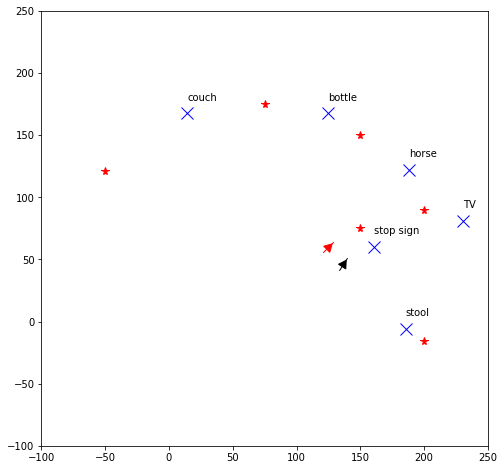

In [31]:
    """ Update robot position on map """
    plt.figure(figsize=(8,8))
    plt.xlim([-100,250])
    plt.ylim([-100,250])
    
    """ Display robot as line + triangle (arrow) """
    robot_x = Mu[0,0]*100
    robot_y = Mu[1,0]*100
    robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
    
    if debug:
        print("(x,y):{:.1f}, {:.1f}".format(robot_x,robot_y))
        print("Orientation: {:.1f}".format(normalize_angle(Mu[2,0])*180/math.pi))
    
    robot_x_actual = 125
    robot_y_actual = 60
    robot_theta_actual = (math.pi*1/4)*180/math.pi - 90 # Adjust orientation to match matplotlib    
    
    # robot = line + triangle
    plt.plot(robot_x, robot_y, marker=(2, 0, robot_theta), c='k',markersize=15, linestyle='None')
    plt.plot(robot_x, robot_y, marker=(3, 0, robot_theta), c='k',markersize=10, linestyle='None')

    # robot = line + triangle
    plt.plot(robot_x_actual, robot_y_actual, marker=(2, 0, robot_theta_actual), \
             c='r',markersize=15, linestyle='None')
    plt.plot(robot_x_actual, robot_y_actual, marker=(3, 0, robot_theta_actual), \
             c='r',markersize=10, linestyle='None')
    
    """ Display landmark as green cross, uncorrected landmark as lime cross """
    for i, landmark in enumerate(landmarks):
        if landmark['observed'] is True:
            # Mark landmark's actual locations
            landmark_x_actual = landmark["actual_x"]*100
            landmark_y_actual = landmark["actual_y"]*100
            plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red') 
            # Mark landmark (post-Kalman correction)
            landmark_x = Mu[3+2*i]*100
            landmark_y = Mu[3+2*i+1]*100
            plt.plot(landmark_x, landmark_y,marker='x', markersize=12, color='blue')
            plt.text(landmark_x, landmark_y+10, landmark["obj_name"])
    
    plt.savefig('diagnostics/map_final.png')
    plt.show()
    plt.close()


## Pursuit + Rotate-in-Place Path Following 

In [55]:
"""
robot_params = {
    # pose
    "start_x": 1.0,
    "start_y": 0.3,
    "start_theta": 0,
    # physical dimensions
    "wheel_radius": 0.0325,
    "axle_length": 0.12,
    "camera_offset": 0.06, # camera is +6cm from center of wheel axle
    "focal_length": 0.00315, # camera focal lenght in meter
    # stepwise motor control
    "motor_on_time": 0.1,  
    "motor_off_time": 0.2,
    # wheel velocity control
    "min_ang_velocity": 6.5, # Equivalent to motor speed setting of 0.3
}

control_params = {
    "num_iter": 301,
    "interval": 10,
    "debug": True,
    "motion": True,
    "speed_lower": 0.14,  # This ensures motor settings > ~0.3
    "speed_upper": 0.25,  # This ensures motor settings > ~0.5
    "omega_upper": 8 # This ensures motor settings > ~0.4
}

"""

pursuit_params = {
    "K_v": 0.5,
    "K_i": 0,
    "K_h": 0.5,
    "lag": 0.02
}

trajec_params = {
    "points": [],   # used for storing evenly spaced points in trajectory
    "current": 0,   # point to the current pursuit point
}


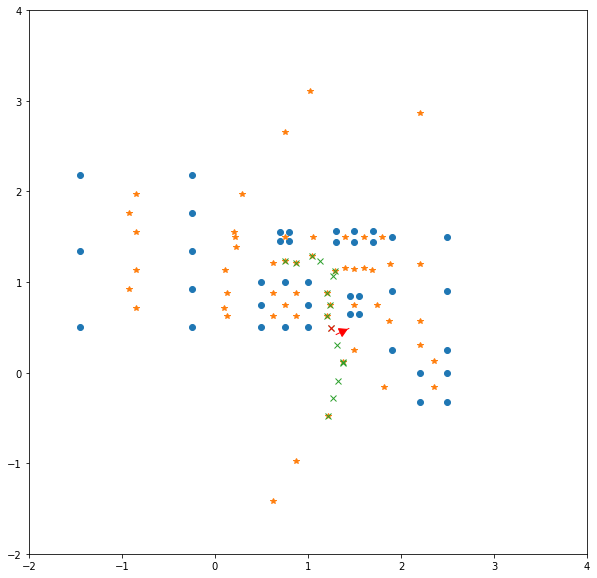

In [57]:

""" Display robot as line + triangle (arrow) """
robot_x = Mu[0,0]
robot_y = Mu[1,0]
robot_theta = Mu[2,0]*180/math.pi - 90 # Adjust orientation to match matplotlib
robot_pose = [robot_x,robot_y,robot_theta]   

# Initialize trajec_params
trajec_params["points"] = generate_trajectory(shortest, vor, 0.20, debug=False)
trajec_params["current"] = 0

# pursuit point is set at the pt in trajectory closest to the robot
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)

display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# Update map
animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)

1 26
26 27
27 11
11 10
10 14
14 21
21 35
35 36
36 23
23 22
22 19
[[ 0.20618]
 [-0.28364]]


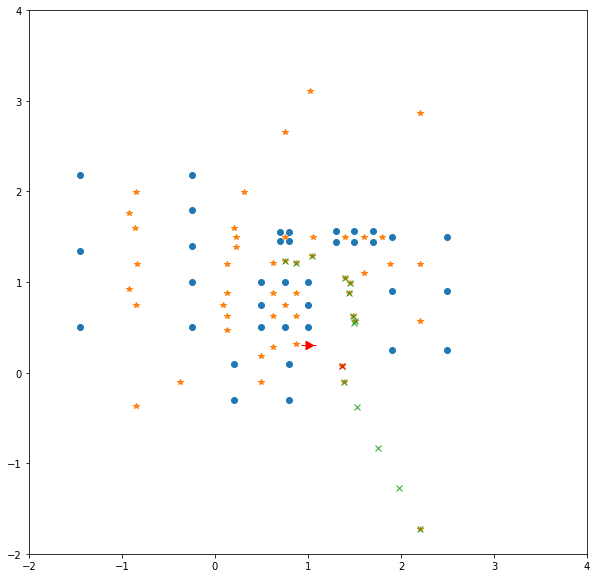

Step:  1
theta:-0.5672700503534143
e:0.4123531926154619 e_theta:-0.5672700503534145
(v,omega): [[ 0.20618]
 [-0.28364]]
(x,y,theta) before: 1.0, 0.3, 0
Clamped wheel Velocities: [[5.82026]
 [6.86753]] (0.3560879026699086, 0.3366219587058224)
(x,y,theta) after: 1.0206148952977305, 0.2997076250813816, -0.028363502517670627
[[ 0.19748]
 [-0.28251]]
[[ 0.18913]
 [-0.28136]]
[[ 0.18113]
 [-0.28019]]
[[ 0.17345]
 [-0.27901]]
[[ 0.16609]
 [-0.27781]]
[[ 0.15902]
 [-0.27658]]
[[ 0.15225]
 [-0.27534]]
[[ 0.14576]
 [-0.27407]]
[[ 0.13954]
 [-0.27278]]
[[ 0.13355]
 [-0.27151]]


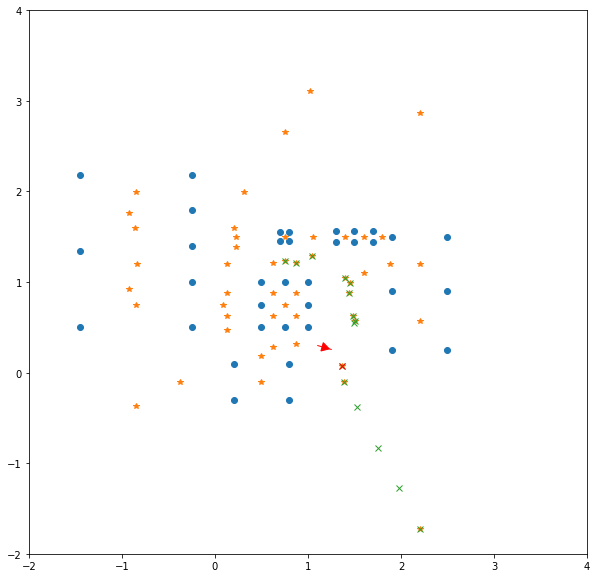

Step:  11
theta:-0.8213505463241854
e:0.2670937144352353 e_theta:-0.5430217217882252
(v,omega): [[ 0.14   ]
 [-0.27151]]
(x,y,theta) before: 1.1690563940415104, 0.27785462728753346, -0.2783288245359603
Clamped wheel Velocities: [[3.80644]
 [4.80894]] (0.31782422170640395, 0.29943430503350804)
(x,y,theta) after: 1.1824637483352278, 0.27382587928004604, -0.3054799106253715
[[ 0.12755]
 [-0.27079]]
[[ 0.12155]
 [-0.27065]]
[[ 0.11555]
 [-0.27116]]
[[ 0.10956]
 [-0.27237]]
[[ 0.10358]
 [-0.27436]]
[[ 0.09762]
 [-0.27723]]
[[ 0.09168]
 [-0.28109]]
[[ 0.08578]
 [-0.28608]]
[[ 0.07991]
 [-0.29239]]
[[ 0.07411]
 [-0.30023]]


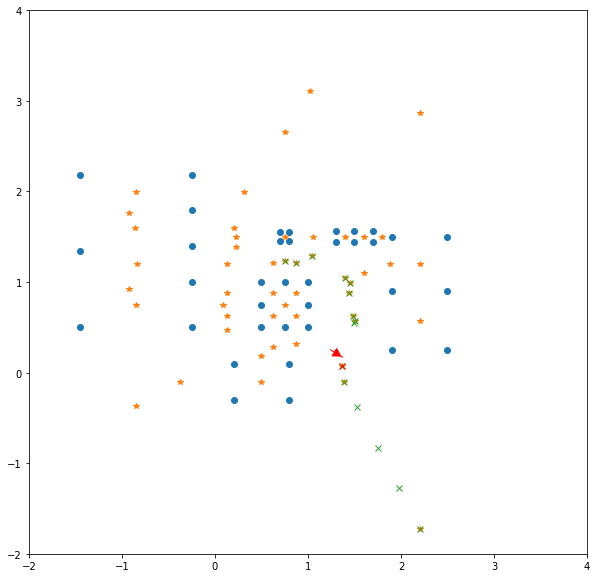

Step:  21
theta:-1.155559643620555
e:0.14821444201372183 e_theta:-0.6004677450607638
(v,omega): [[ 0.14   ]
 [-0.30023]]
(x,y,theta) before: 1.2967753450667558, 0.2216026513337891, -0.5550918985597912
Clamped wheel Velocities: [[3.75341]
 [4.86197]] (0.31880985550576124, 0.2987456414178532)
(x,y,theta) after: 1.308560733379456, 0.21404686548235047, -0.5851152858128295
[[ 0.06837]
 [-0.30991]]
[[ 0.06272]
 [-0.32178]]
[[ 0.05718]
 [-0.33629]]
[[ 0.05178]
 [-0.35405]]
[[ 0.04656]
 [-0.3758 ]]
[[ 0.04157]
 [-0.40247]]


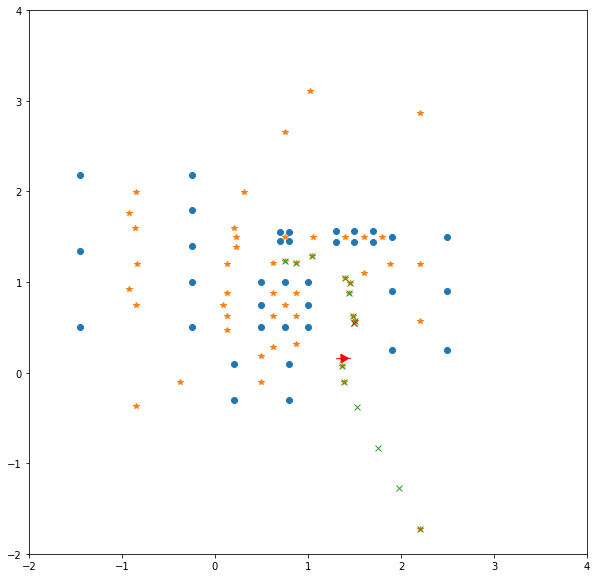

Step:  31
theta:1.2595681000540353
e:0.38803047766117954 e_theta:1.2297134444918063
(v,omega): [[0.  ]
 [2.75]]
(x,y,theta) before: 1.3735056853739689, 0.16101393462651103, 0.029854655562228827
Clamped wheel Velocities: [[ 5.07692]
 [-5.07692]] (-0.322805261652845, 0.32280526165284557)
(x,y,theta) after: 1.3735056853739689, 0.16101393462651103, 0.30485465556222885
[[0.19402]
 [0.06486]]
[[0.1844 ]
 [0.06476]]
[[0.17525]
 [0.06466]]
[[0.16656]
 [0.06454]]
[[0.1583 ]
 [0.06442]]
[[0.15045]
 [0.06429]]
[[0.14299]
 [0.06415]]


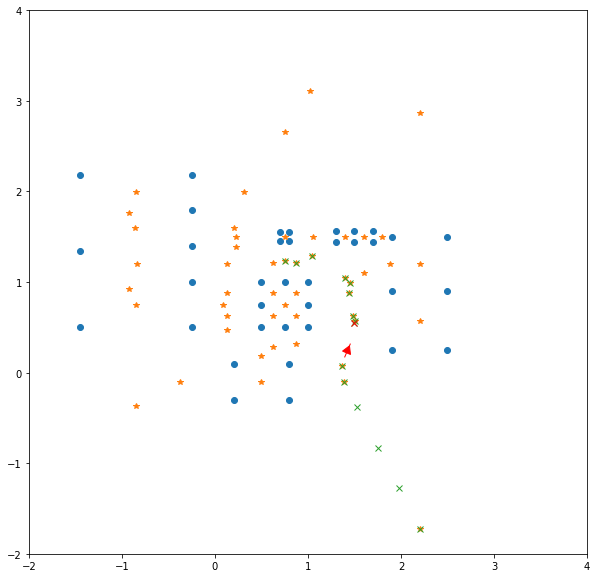

Step:  41
theta:1.2969123682178143
e:0.28598774629536355 e_theta:0.12830416677257972
(v,omega): [[0.14299]
 [0.06415]]
(x,y,theta) before: 1.4156947580526436, 0.25485901594314214, 1.1686082014452348
Clamped wheel Velocities: [[4.51825]
 [4.28138]] (0.30801815736031213, 0.3124209311700661)
(x,y,theta) after: 1.4212497621839189, 0.2680352713074925, 1.1750234097838639
[[0.1359]
 [0.064 ]]
[[0.12896]
 [0.06394]]
[[0.12202]
 [0.06404]]
[[0.11507]
 [0.06432]]
[[0.10813]
 [0.06481]]
[[0.10119]
 [0.06554]]
[[0.09425]
 [0.06654]]
[[0.08732]
 [0.06787]]
[[0.08038]
 [0.06958]]
[[0.07345]
 [0.07178]]


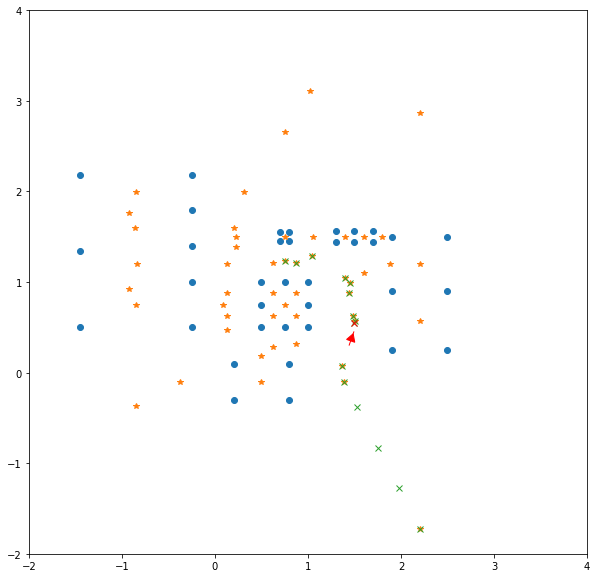

Step:  51
theta:1.3776402935886107
e:0.14690397009973566 e_theta:0.1435537272805698
(v,omega): [[0.14   ]
 [0.07178]]
(x,y,theta) before: 1.466417661595278, 0.38564177451880244, 1.2340865663080411
Clamped wheel Velocities: [[4.4402 ]
 [4.17518]] (0.30604425975498056, 0.31097032417410225)
(x,y,theta) after: 1.4709955672839836, 0.3988721160875902, 1.2412642526720696
[[0.06653]
 [0.07457]]
[[0.05961]
 [0.07813]]
[[0.0527 ]
 [0.08269]]
[[0.0458 ]
 [0.08863]]
[[0.05204]
 [0.07875]]
[[0.04513]
 [0.08452]]
[[0.0633 ]
 [0.18458]]
[[0.05679]
 [0.19381]]
[[0.05034]
 [0.06803]]


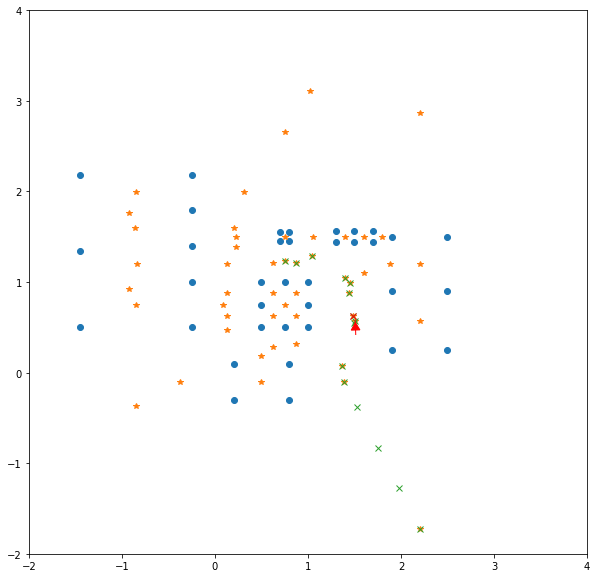

Step:  61
theta:1.7388875053120232
e:0.10068815708932174 e_theta:0.13605575701913164
(v,omega): [[0.14   ]
 [0.06803]]
(x,y,theta) before: 1.503524550915315, 0.5060128326491722, 1.6028317482928918
Clamped wheel Velocities: [[4.43328]
 [4.1821 ]] (0.3061729066568068, 0.3108416772722761)
(x,y,theta) after: 1.5030285402836006, 0.5200040162153206, 1.6096345361438484
[[0.04341]
 [0.07329]]
[[0.16319]
 [0.06509]]
[[0.1551 ]
 [0.06496]]
[[0.14741]
 [0.06483]]
[[0.1401 ]
 [0.06468]]
[[0.13315]
 [0.06452]]
[[0.12621]
 [0.06452]]
[[0.11927]
 [0.06469]]
[[0.11233]
 [0.06506]]
[[0.10539]
 [0.06564]]


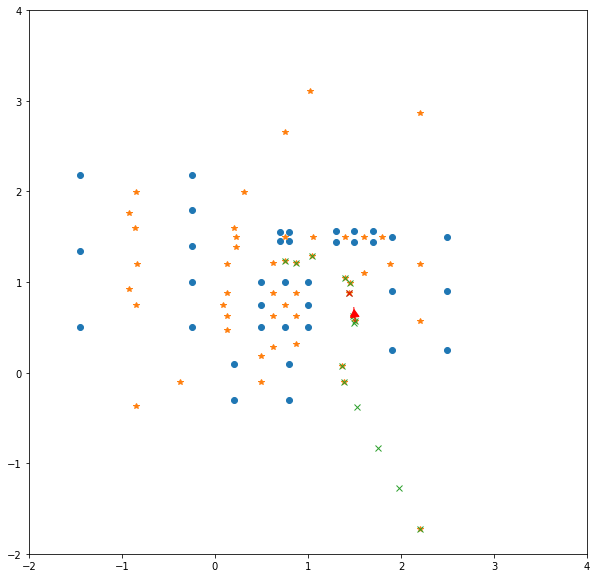

Step:  71
theta:1.8000896967012199
e:0.21077882269077775 e_theta:0.13128940051580962
(v,omega): [[0.14   ]
 [0.06564]]
(x,y,theta) before: 1.4941202571243364, 0.6502612942756845, 1.66880029618541
Clamped wheel Velocities: [[4.42888]
 [4.1865 ]] (0.30625468572177655, 0.31075989820730626)
(x,y,theta) after: 1.4927046760916685, 0.6641895183728408, 1.6753647662112006
[[0.09845]
 [0.06648]]
[[0.09151]
 [0.06762]]
[[0.08458]
 [0.0691 ]]
[[0.07765]
 [0.07101]]
[[0.07072]
 [0.07344]]
[[0.0638 ]
 [0.07654]]
[[0.05688]
 [0.0805 ]]
[[0.04998]
 [0.08559]]
[[0.04309]
 [0.09227]]
[[ 0.09004]
 [-0.03301]]


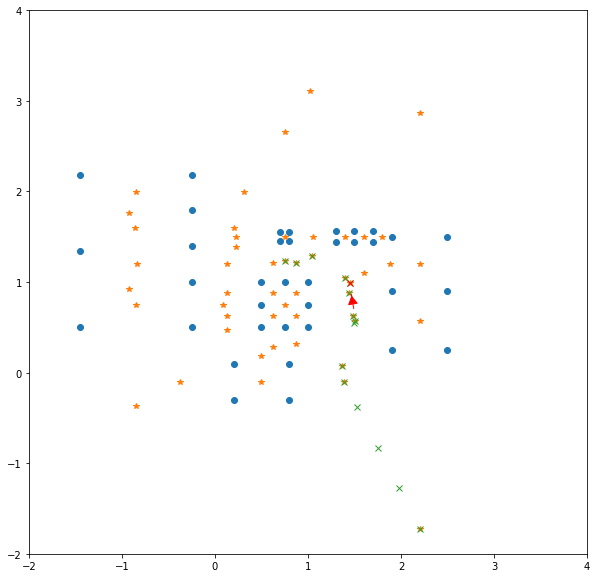

Step:  81
theta:1.6776039583720326
e:0.1800859173578582 e_theta:-0.06601573648002912
(v,omega): [[ 0.14   ]
 [-0.03301]]
(x,y,theta) before: 1.475545340384432, 0.7889914949071807, 1.7436196948520615
Clamped wheel Velocities: [[4.24675]
 [4.36863]] (0.30963996116351244, 0.30737462276557037)
(x,y,theta) after: 1.4731606052900141, 0.8027868876371717, 1.74031890802806
[[ 0.08306]
 [-0.03378]]
[[ 0.07607]
 [-0.03476]]
[[ 0.06909]
 [-0.03602]]
[[ 0.06211]
 [-0.03763]]
[[ 0.05513]
 [-0.03969]]
[[ 0.04816]
 [-0.04236]]
[[ 0.04118]
 [-0.04588]]
[[0.07037]
 [0.11285]]
[[0.06355]
 [0.1176 ]]
[[0.05676]
 [0.12363]]


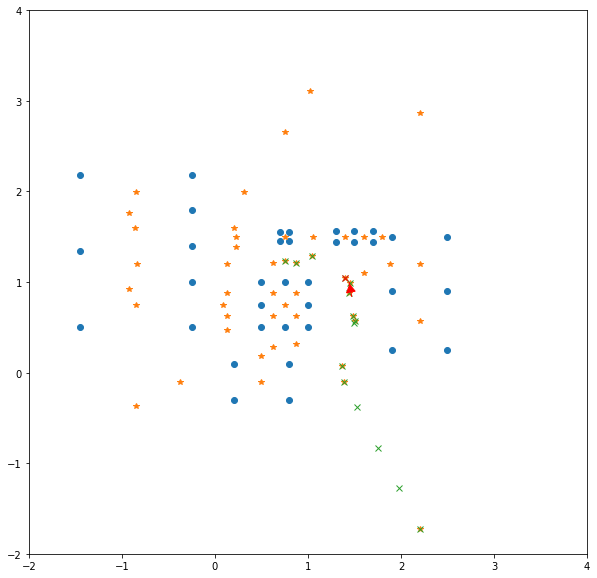

Step:  91
theta:1.9836207464559092
e:0.1135115347572145 e_theta:0.24726878925659745
(v,omega): [[0.14   ]
 [0.12363]]
(x,y,theta) before: 1.4535645698941175, 0.9272500467605131, 1.7363519571993118
Clamped wheel Velocities: [[4.53594]
 [4.07944]] (0.30426476198015595, 0.31274982194892686)
(x,y,theta) after: 1.4511720635500447, 0.9410440098161613, 1.7487153966621418
[[0.04998]
 [0.13139]]
[[0.04324]
 [0.14148]]
[[0.24626]
 [0.06844]]
[[0.23407]
 [0.06837]]
[[0.22247]
 [0.0683 ]]
[[0.21145]
 [0.06822]]
[[0.20098]
 [0.06813]]
[[0.19102]
 [0.06804]]


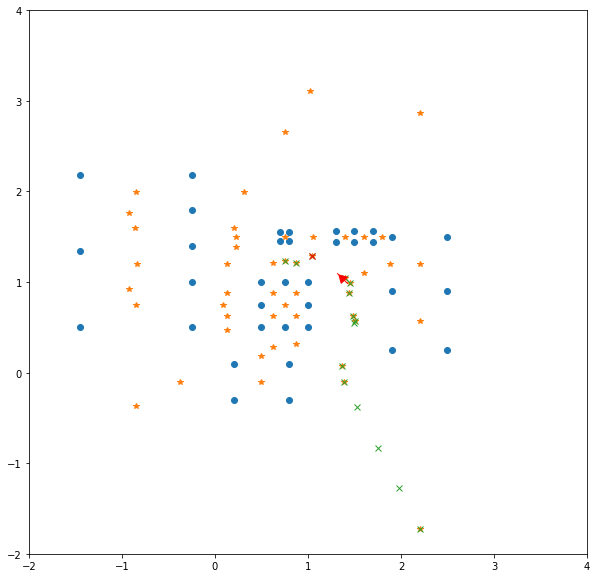

Step:  101
theta:2.496227511179055
e:0.38204157972910835 e_theta:0.13607815042974014
(v,omega): [[0.19102]
 [0.06804]]
(x,y,theta) before: 1.3680888834512193, 1.048467416196725, 2.3601493607493147
Clamped wheel Velocities: [[6.00317]
 [5.75195]] (0.33535227071870966, 0.34002180976691354)
(x,y,theta) after: 1.3544826963610965, 1.0618748651270238, 2.3669532682708017
[[0.18156]
 [0.06794]]
[[0.17256]
 [0.06782]]
[[0.16401]
 [0.0677 ]]
[[0.15589]
 [0.06757]]
[[0.14817]
 [0.06743]]
[[0.14082]
 [0.06728]]
[[0.13385]
 [0.06711]]
[[0.12691]
 [0.06709]]
[[0.11997]
 [0.06725]]
[[0.11304]
 [0.06761]]


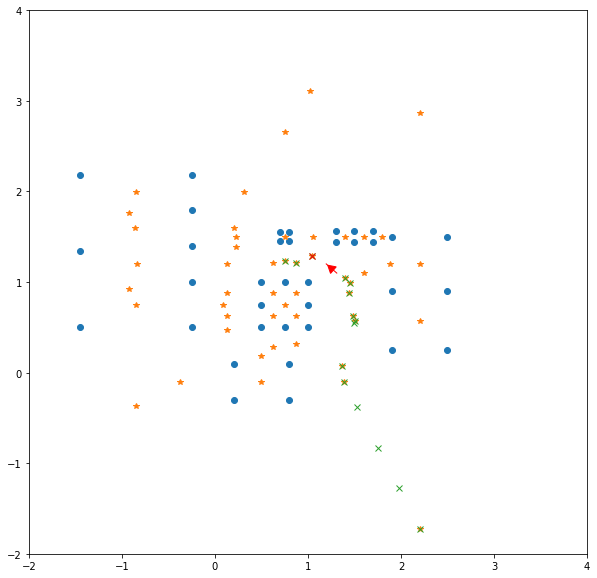

Step:  111
theta:2.5628932152898405
e:0.22607124014850327 e_theta:0.13522069764217282
(v,omega): [[0.14   ]
 [0.06761]]
(x,y,theta) before: 1.252910441628934, 1.1557063578733906, 2.4276725176476677
Clamped wheel Velocities: [[4.43251]
 [4.18287]] (0.3061872342411984, 0.3108273496878844)
(x,y,theta) after: 1.2422983215048824, 1.164837741112044, 2.4344335525297764
[[0.1061 ]
 [0.06819]]
[[0.09917]
 [0.06903]]
[[0.09223]
 [0.07018]]
[[0.0853 ]
 [0.07168]]
[[0.07838]
 [0.07361]]
[[0.07146]
 [0.07608]]
[[0.06454]
 [0.07921]]
[[0.05763]
 [0.08322]]
[[0.05073]
 [0.08837]]
[[0.04385]
 [0.09509]]


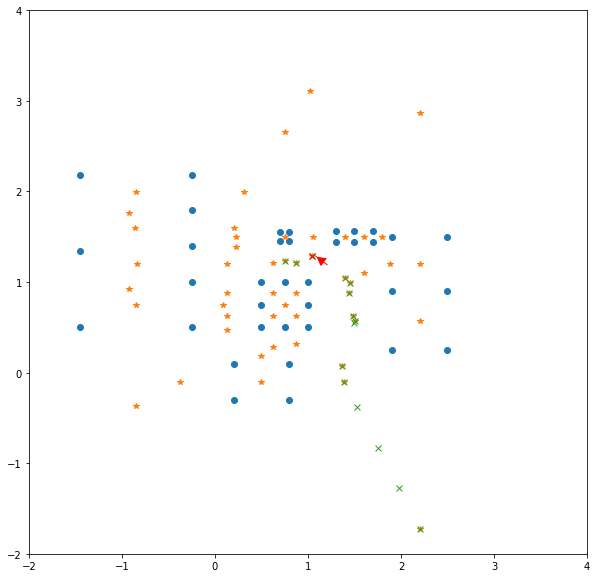

Step:  121
theta:2.692577285129525
e:0.08770222885254753 e_theta:0.1901866775496015
(v,omega): [[0.14   ]
 [0.09509]]
(x,y,theta) before: 1.1439320692600339, 1.2435402347404798, 2.5023906075799234
Clamped wheel Velocities: [[4.48325]
 [4.13214]] (0.3052441519436732, 0.31177043198540966)
(x,y,theta) after: 1.1326565204825716, 1.2518384588149527, 2.5118999414574037
[[0.12022]
 [0.11296]]
[[0.1134 ]
 [0.11351]]
[[0.10658]
 [0.11443]]
[[0.09976]
 [0.11576]]
[[0.09295]
 [0.11759]]
[[0.08615]
 [0.11998]]
[[0.07935]
 [0.12306]]
[[0.07257]
 [0.12699]]


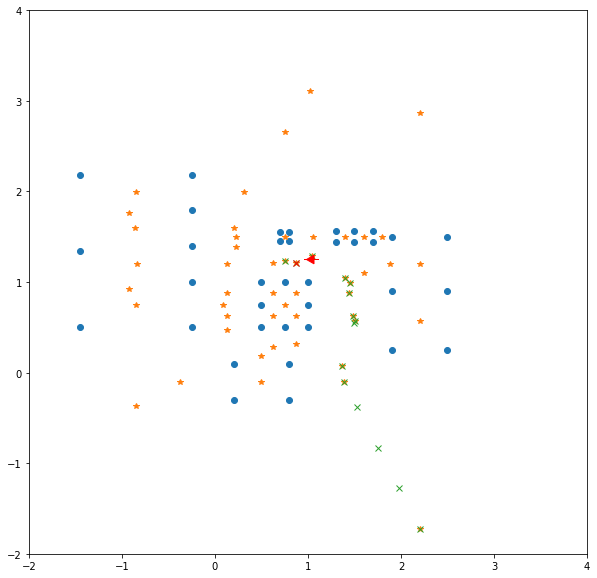

Step:  131
theta:-2.8855839979549573
e:0.1451422656234909 e_theta:0.2539709980435747
(v,omega): [[0.14   ]
 [0.12699]]
(x,y,theta) before: 1.0347600107869335, 1.255706431243964, 3.143630311181054
Clamped wheel Velocities: [[4.54213]
 [4.07326]] (0.3041497684064589, 0.31286481552262396)
(x,y,theta) after: 1.0207605972293605, 1.2555890163537986, 3.156328861083233
[[0.0658 ]
 [0.13195]]
[[0.05906]
 [0.13826]]
[[0.05234]
 [0.1463 ]]
[[0.04566]
 [0.15668]]
[[0.09816]
 [0.02291]]
[[0.09117]
 [0.02331]]
[[0.08418]
 [0.02383]]
[[0.07718]
 [0.02451]]
[[0.07019]
 [0.02537]]
[[0.0632 ]
 [0.02646]]


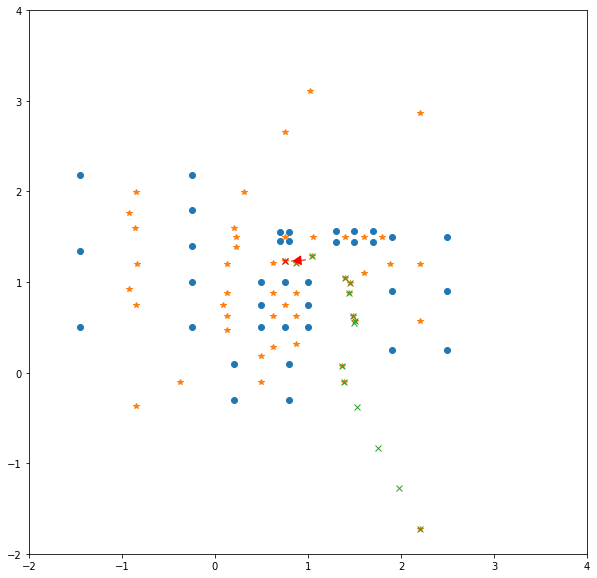

Step:  141
theta:-3.0046222396180573
e:0.12640251425949858 e_theta:0.052922683813768856
(v,omega): [[0.14   ]
 [0.02646]]
(x,y,theta) before: 0.8950313389302732, 1.2477679481020871, 3.2256403837477605
Clamped wheel Velocities: [[4.35654]
 [4.25884]] (0.3075992676497498, 0.309415316279333)
(x,y,theta) after: 0.8810823292334155, 1.2465742085531912, 3.2282865179384492
[[0.05621]
 [0.02786]]
[[0.04922]
 [0.02968]]
[[0.04224]
 [0.03207]]


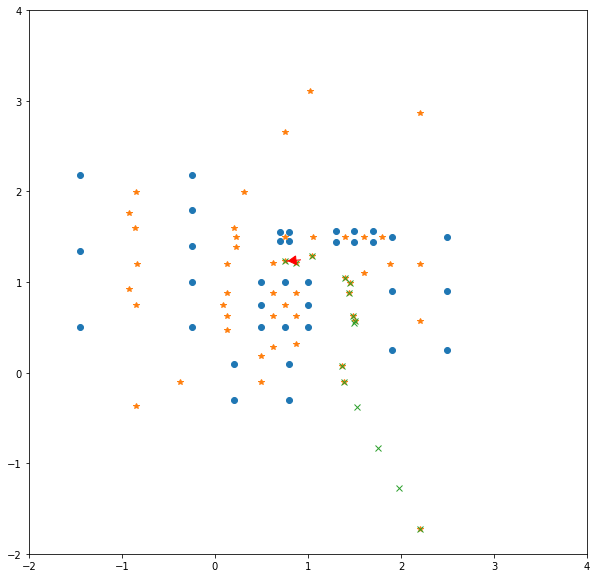

End of Trajectory!!!


In [251]:
def path_pursuit(error_pos, error_theta, sum_errors, speed_upper_limit, speed_lower_limit, T, debug=False):
    """ PID controller for point pursuit """
    
    # PI Controller for v
    v = K_v*error_pos + K_i*sum_errors  # P-componet
    sum_errors += error_pos  # I-Component

    # P Controller for omega
    omega = K_h*error_theta

    """ Clamp motor setting to (0.3-0.5) """
    unclamped_robot_velocities = np.array([[v],[omega]])
    inv_T = np.linalg.pinv(T)
    unclamped_wheel_velocities = np.dot(inv_T, unclamped_robot_velocities)
    wheel_velocities = clamp(unclamped_wheel_velocities, speed_upper_limit, \
                                 speed_lower_limit, T, debug=debug) 
    robot_velocities = np.dot(T, wheel_velocities)
    
    return wheel_velocities, robot_velocities, sum_errors

def rotate_in_place(error_theta, T, debug=False):
    """ PID controller for rotation in place """

    # P Controller for omega; zero translational velocity
    omega = 2.75 * error_theta/abs(error_theta)   # omega is set at +/-2.75
    v = 0
    
    robot_velocities = np.array([[v],[omega]])
    inv_T = np.linalg.pinv(T)
    wheel_velocities = np.dot(inv_T, robot_velocities)    
    
    return wheel_velocities, robot_velocities


# load control parameters 
num_iter = control_params["num_iter"]
interval = control_params["interval"]
motion = control_params["motion"]
debug = control_params["debug"]
speed_lower_limit = control_params["speed_lower"]
speed_upper_limit = control_params["speed_upper"]
omega_upper_limit = control_params["omega_upper"]

# load robot parameters

wheel_radius = robot_params["wheel_radius"]
axle_length = robot_params["axle_length"]
motor_on_time = robot_params["motor_on_time"]
motor_off_time = robot_params["motor_off_time"]
min_ang_velocity = robot_params["min_ang_velocity"]
dt = robot_params["motor_on_time"]
robot_pose = [robot_params["start_x"],robot_params["start_y"],robot_params["start_theta"]]

T = control2robot(wheel_radius, axle_length)

# load trajectory parameters
trajec_params["points"] = generate_trajectory(shortest, vor, 0.5, debug=True)
trajec_params["current"] = 0  # current points to trajectory's first pt

# Map parameters
display_param = {
    "figsize": (10,10),
    "xlim": [-2,4],
    "ylim": [-2,4]
    }

# the point in the trajectory closed to the robot is the pursuit point, update current
trajec_params["current"], pursuit_pt = closest_point(trajec_params,robot_pose)
pursuit_x = pursuit_pt[0]
pursuit_y = pursuit_pt[1]

K_v = pursuit_params['K_v']
K_i = pursuit_params['K_i']
K_h = pursuit_params['K_h']
lag = pursuit_params['lag']

robot_x = robot_pose[0]
robot_y = robot_pose[1]
robot_theta = robot_pose[2]
sum_errors = 0

""" Robot pursuit a moving point """
for i in range(num_iter):
    
    robot_pos = [robot_x ,robot_y]
    
    """ =================== """        
    """ Pursuit Following   """
    """ =================== """

    # Get the next pursuit point 
    pursuit_pt = next_pursuit_pt(robot_pose, pursuit_pt, trajec_params)
    if pursuit_pt is None:  
        # Exit loop if end of trajectory reached
        break
    pursuit_x = pursuit_pt[0]
    pursuit_y = pursuit_pt[1]
    
    # Calculate positional and angular errors
    error_pos = distance(robot_pos,pursuit_pt)-lag
    theta = math.atan2((pursuit_y-robot_y),(pursuit_x-robot_x))
    error_theta =  normalize_angle(theta-robot_theta)  # critical to normalize angle!!!

    if error_theta < math.pi/8:
        # Pursuit-based path following if large turn not required
        wheel_velocities, robot_velocities, sum_errors = path_pursuit(error_pos, error_theta, sum_errors, \
                                                      speed_upper_limit, speed_lower_limit, T, debug=False)
    else:
        # Rotate-in-place if large turn required (Hardcoded at motor setting of 0.31 --> 0.275 rad turn)
        wheel_velocities, robot_velocities = rotate_in_place(error_theta, T, debug=False)   
        
    v = robot_velocities[0,0]
    omega = robot_velocities[1,0]
    
    """ Move robot """
    # Map wheel angular velocities to motor setting, then run motors 
    w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
    w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)
        
    if motion:
        """ Run motor step motion """
        robot.set_motors(w_l, w_r)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)
        
    # robot_velocities = (v,omega)
    d_x,d_y,d_theta = robot_pose_delta(v,omega,robot_theta,dt)

    if i%interval==0:
        animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
        print("Step: ", i+1)
        print("theta:{}".format(theta))
        print("e:{} e_theta:{}".format(error_pos, error_theta))
        print("(v,omega): {}".format(robot_velocities))
        print("(x,y,theta) before: {}, {}, {}".format(robot_x,robot_y,robot_theta))
        print("Clamped wheel Velocities:", wheel_velocities, (w_l, w_r))
    
    robot_x += d_x
    robot_y += d_y
    robot_theta += d_theta
    robot_pose = [robot_x,robot_y,robot_theta]
    
    if i%interval==0:
        print("(x,y,theta) after: {}, {}, {}".format(robot_x,robot_y,robot_theta))

animate_robot(robot_pose, points, vor, display_param, path=trajec_params["points"], pursuit_pt=pursuit_pt)
print("End of Trajectory!!!")

In [136]:
robot.stop()

In [252]:
motion = True
speed = 0.31

for i in range(20):
    if motion:
        """ Run motor step motion """
        robot.set_motors(speed, -speed)  # left, right
        time.sleep(motor_on_time)
        robot.stop()
        time.sleep(motor_off_time)

In [243]:
error_theta = -math.pi*0.3

omega = 2.75 * error_theta/abs(error_theta)   # omega is set at +/-2.75
v = 0

robot_velocities = np.array([[v],[omega]])
inv_T = np.linalg.pinv(T)
wheel_velocities = np.dot(inv_T, robot_velocities) 

print(wheel_velocities)

w_r = omega2speed(wheel_velocities[0,0],wheel_calibration) 
w_l = omega2speed(wheel_velocities[1,0],wheel_calibration)

print(w_l, w_r)

[[-5.07692]
 [ 5.07692]]
0.322805261652845 -0.32280526165284557


In [245]:
robot_pose_delta(v,omega,9,dt)

(-0.0, 0.0, -0.275)